# Data Science I Project

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


## Utils

In [3]:
def create_frequency_table_with_credit_risk(index: str, df: pd.DataFrame):
    cross_table_credit_hist = pd.crosstab(df[index], df["CreditRiskClass"], margins=True)
    cross_table_credit_hist[f"P(Bad|{index})"] = cross_table_credit_hist["Bad"]/cross_table_credit_hist["All"]
    cross_table_credit_hist[f"P(Good|{index})"] = 1 - cross_table_credit_hist[f"P(Bad|{index})"]
    return cross_table_credit_hist

def detect_rare_categories(dataset_df: pd.DataFrame, threshold: int):
    categorical_cols = dataset_df.select_dtypes("object")
    
    for col_name in categorical_cols:
        rel_freq_s = dataset_df[col_name].value_counts(normalize=True)*100
        
        below_threshold = rel_freq_s[rel_freq_s < threshold].index.to_list()
        
        if (len(below_threshold)): 
            print(f"\n Categories in Feature {col_name} below threshold freq: {below_threshold}")
            print("Relative Frequency: ")
            print(rel_freq_s)

def merge_categories(dataset_df: pd.DataFrame, feature: str, categories_to_merge: list, merged_category_name: str):
    dataset_df[feature] = dataset_df[feature].apply(lambda value: merged_category_name if value in categories_to_merge else value)
    return dataset_df

## Loading Dataset

In [4]:
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144)

In [5]:
statlog_german_credit_data.data.original

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


In [6]:
metadata = statlog_german_credit_data.metadata

print("Abstract: ", metadata["abstract"])
print("Area: ", metadata["area"])
print("Number of Instances: ", metadata["num_instances"])
print("Has Missing Values: ", metadata["has_missing_values"])
print("Number of Features: ", metadata["num_features"])
print("Feature Types: ", metadata["feature_types"])
print("Demographics: ", metadata["demographics"])

Abstract:  This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix
Area:  Social Science
Number of Instances:  1000
Has Missing Values:  no
Number of Features:  20
Feature Types:  ['Categorical', 'Integer']
Demographics:  ['Other', 'Marital Status', 'Age', 'Occupation']


In [7]:
statlog_german_credit_data.variables

,name,role,type,demographic,description,units,missing_values
0,Attribute1,Feature,Categorical,None,Status of existing checking account,None,no
1,Attribute2,Feature,Integer,None,Duration,months,no
2,Attribute3,Feature,Categorical,None,Credit history,None,no
3,Attribute4,Feature,Categorical,None,Purpose,None,no
4,Attribute5,Feature,Integer,None,Credit amount,None,no
5,Attribute6,Feature,Categorical,None,Savings account/bonds,None,no
6,Attribute7,Feature,Categorical,Other,Present employment since,None,no
7,Attribute8,Feature,Integer,None,Installment rate in percentage of disposable i...,None,no
8,Attribute9,Feature,Categorical,Marital Status,Personal status and sex,None,no
9,Attribute10,Feature,Categorical,None,Other debtors / guarantors,None,no


## Preprocessing Data

In this part, the categorical features will be transformed into easier understandable data, so that the EDA can be performed.
Besides, categories in some features will be joined to avoid overfitting

In [8]:
dataset_df = statlog_german_credit_data.data.original

COLUMN_RENAME_DICT = {
    'Attribute1': 'CheckingAccountStatus',
    'Attribute2': 'DurationInMonths',
    'Attribute3': 'CreditHistory',
    'Attribute4': 'Purpose',
    'Attribute5': 'CreditAmount',
    'Attribute6': 'SavingsAccountBonds',
    'Attribute7': 'EmploymentSince',
    'Attribute8': 'InstallmentRate',
    'Attribute9': 'PersonalStatusSex',
    'Attribute10': 'OtherDebtorsGuarantors',
    'Attribute11': 'ResidenceSince',
    'Attribute12': 'Property',
    'Attribute13': 'Age',
    'Attribute14': 'OtherInstallmentPlans',
    'Attribute15': 'Housing',
    'Attribute16': 'ExistingCreditsCount',
    'Attribute17': 'Job',
    'Attribute18': 'PeopleLiableMaintenance',
    'Attribute19': 'Telephone',
    'Attribute20': 'ForeignWorker',
    'class': 'CreditRiskClass'
}

dataset_df = dataset_df.rename(columns = COLUMN_RENAME_DICT)


Below, the mappings for the categorical data are defined

In [9]:
# Consolidated mapping dictionary for all categorical columns
categorical_mappings = {
    'CheckingAccountStatus': {
        'A11': 'Less than 0 DM',
        'A12': '0 to 200 DM',
        'A13': '200 DM or more',
        'A14': 'No checking account'
    },
    'CreditHistory': {
        'A30': 'No credits taken', # individual has never taken out any credits
        'A31': 'All credits at this bank paid back duly', # individual has taken out credits from this particular bank and has paid them all back on time
        'A32': 'Existing credits paid back duly till now', # individual currently has existing credits and has been paying them back on time up to the present moment.
        'A33': 'Delay in paying off in the past', # individual has experienced delays in making credit payments in the past
        'A34': 'Critical account / other credits existing'
    },
    'Purpose': {
        'A40': 'Car (new)',
        'A41': 'Car (used)',
        'A42': 'Furniture/equipment',
        'A43': 'Radio/television',
        'A44': 'Domestic appliances',
        'A45': 'Repairs',
        'A46': 'Education',
        'A47': 'Vacation',
        'A48': 'Retraining',
        'A49': 'Business',
        'A410': 'Others'
    },
    'SavingsAccountBonds': {
        'A61': 'Less than 100 DM',
        'A62': '100 to 500 DM',
        'A63': '500 to 1000 DM',
        'A64': '1000 DM or more',
        'A65': 'Unknown / no savings account'
    },
    'EmploymentSince': {
        'A71': 'Unemployed',
        'A72': 'Less than 1 year',
        'A73': '1 to 4 years',
        'A74': '4 to 7 years',
        'A75': '7 years or more'
    },
    'PersonalStatusSex': {
        'A91': 'Male: divorced',
        'A92': 'Female: divorced/married',
        'A93': 'Male: single',
        'A94': 'Male: married/widowed',
        'A95': 'Female: single'
    },
    'OtherDebtorsGuarantors': {
        'A101': 'None',
        'A102': 'Co-applicant',
        'A103': 'Guarantor'
    },
    'Property': {
        'A121': 'Real estate',
        'A122': 'Building society savings agreement / life insurance',
        'A123': 'Car or other, not in attribute 6',
        'A124': 'Unknown / no property'
    },
    'OtherInstallmentPlans': {
        'A141': 'Bank',
        'A142': 'Stores',
        'A143': 'None'
    },
    'Housing': {
        'A151': 'Rent',
        'A152': 'Own',
        'A153': 'For free'
    },
    'Job': {
        'A171': 'Unemployed / unskilled - non-resident',
        'A172': 'Unskilled - resident',
        'A173': 'Skilled employee / official',
        'A174': 'Management / self-employed / \n highly qualified employee / officer'
    },
    'Telephone': {
        'A191': 'None',
        'A192': 'Yes, registered under the customer\'s name'
    },
    'ForeignWorker': {
        'A201': 'Yes',
        'A202': 'No'
    }
}

In [10]:
# replacing codes with descriptive labels using the consolidated mappings
for column, mapping in categorical_mappings.items():
    dataset_df[column] = dataset_df[column].replace(mapping)

# Separating Personal Status from Gender in original feature "PersonalStatusSex" 
dataset_df["Gender"] = dataset_df["PersonalStatusSex"].str.extract("([A-Za-z]+)")
dataset_df["PersonalStatus"] = dataset_df["PersonalStatusSex"].str.extract("(?<=:\s)(.*)$")
dataset_df = dataset_df.drop("PersonalStatusSex", axis=1)

# Replace values of the target variable, as defined in the instructions of the dataset 
dataset_df["CreditRiskClass"] = dataset_df["CreditRiskClass"].replace(1,0) # Good payer, low risk
dataset_df["CreditRiskClass"] = dataset_df["CreditRiskClass"].replace(2,1) # Bad payer. high risk

credit_risk_class_map = ["Good", "Bad"]

dataset_df["CreditRiskClass"] = dataset_df["CreditRiskClass"].apply(lambda risk_class: credit_risk_class_map[risk_class])

print("New columns: ", dataset_df.columns)

New columns:  Index(['CheckingAccountStatus', 'DurationInMonths', 'CreditHistory', 'Purpose',
       'CreditAmount', 'SavingsAccountBonds', 'EmploymentSince',
       'InstallmentRate', 'OtherDebtorsGuarantors', 'ResidenceSince',
       'Property', 'Age', 'OtherInstallmentPlans', 'Housing',
       'ExistingCreditsCount', 'Job', 'PeopleLiableMaintenance', 'Telephone',
       'ForeignWorker', 'CreditRiskClass', 'Gender', 'PersonalStatus'],
      dtype='object')


In [11]:
detect_rare_categories(dataset_df, 5)


 Categories in Feature CreditHistory below threshold freq: ['All credits at this bank paid back duly', 'No credits taken']
Relative Frequency: 
CreditHistory
Existing credits paid back duly till now     53.0
Critical account / other credits existing    29.3
Delay in paying off in the past               8.8
All credits at this bank paid back duly       4.9
No credits taken                              4.0
Name: proportion, dtype: float64

 Categories in Feature Purpose below threshold freq: ['Repairs', 'Domestic appliances', 'Others', 'Retraining']
Relative Frequency: 
Purpose
Radio/television       28.0
Car (new)              23.4
Furniture/equipment    18.1
Car (used)             10.3
Business                9.7
Education               5.0
Repairs                 2.2
Domestic appliances     1.2
Others                  1.2
Retraining              0.9
Name: proportion, dtype: float64

 Categories in Feature SavingsAccountBonds below threshold freq: ['1000 DM or more']
Relative Frequenc

In [12]:
# Rare categories are merged to reduce complexity and avoid overfitting

dataset_df = merge_categories(dataset_df, feature="CreditHistory",
                 categories_to_merge=["All credits at this bank paid back duly", "No credits taken"],
                 merged_category_name="No credits taken or all credits paid back duly")

dataset_df = merge_categories(dataset_df, feature="Purpose",
                 categories_to_merge=["Retraining", "Domestic appliances", "Repairs", "Education"],
                 merged_category_name="Others")

dataset_df = merge_categories(dataset_df, feature="SavingsAccountBonds",
                              categories_to_merge=["500 to 1000 DM", "1000 DM or more"],
                              merged_category_name="500 DM or more")

dataset_df = merge_categories(dataset_df, feature="OtherDebtorsGuarantors",
                 categories_to_merge=["Guarantor", "Co-applicant"],
                 merged_category_name="Yes")
dataset_df["OtherDebtorsGuarantors"] = dataset_df["OtherDebtorsGuarantors"].replace("None", "No")

dataset_df = merge_categories(dataset_df, feature="OtherInstallmentPlans",
                 categories_to_merge=["Bank", "Stores"],
                 merged_category_name="Yes")
dataset_df["OtherInstallmentPlans"] = dataset_df["OtherInstallmentPlans"].replace("None", "No")

dataset_df = merge_categories(dataset_df, feature="Job",
                 categories_to_merge=["Unskilled - resident", "Unemployed / unskilled - non-resident"],
                 merged_category_name="Unemployed/Unskilled")
dataset_df["OtherInstallmentPlans"] = dataset_df["OtherInstallmentPlans"].replace("None", "No")


In [13]:
detect_rare_categories(dataset_df, 5)


 Categories in Feature ForeignWorker below threshold freq: ['No']
Relative Frequency: 
ForeignWorker
Yes    96.3
No      3.7
Name: proportion, dtype: float64


Although only 37 samples out of 1000 have the ForeignWorker = 1, this feature could still be useful for the credit risk prediction. However, This is a sign that this feature could potentially lead to overfitting. Future steps will evaluate if this feature is necessary or not.

## EDA

In [14]:
print(dataset_df.describe())

       DurationInMonths  CreditAmount  InstallmentRate  ResidenceSince  \
count       1000.000000   1000.000000      1000.000000     1000.000000   
mean          20.903000   3271.258000         2.973000        2.845000   
std           12.058814   2822.736876         1.118715        1.103718   
min            4.000000    250.000000         1.000000        1.000000   
25%           12.000000   1365.500000         2.000000        2.000000   
50%           18.000000   2319.500000         3.000000        3.000000   
75%           24.000000   3972.250000         4.000000        4.000000   
max           72.000000  18424.000000         4.000000        4.000000   

               Age  ExistingCreditsCount  PeopleLiableMaintenance  
count  1000.000000           1000.000000              1000.000000  
mean     35.546000              1.407000                 1.155000  
std      11.375469              0.577654                 0.362086  
min      19.000000              1.000000                 1.00

In [15]:
print(dataset_df.info())
number_samples = len(dataset_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   CheckingAccountStatus    1000 non-null   object
 1   DurationInMonths         1000 non-null   int64 
 2   CreditHistory            1000 non-null   object
 3   Purpose                  1000 non-null   object
 4   CreditAmount             1000 non-null   int64 
 5   SavingsAccountBonds      1000 non-null   object
 6   EmploymentSince          1000 non-null   object
 7   InstallmentRate          1000 non-null   int64 
 8   OtherDebtorsGuarantors   1000 non-null   object
 9   ResidenceSince           1000 non-null   int64 
 10  Property                 1000 non-null   object
 11  Age                      1000 non-null   int64 
 12  OtherInstallmentPlans    1000 non-null   object
 13  Housing                  1000 non-null   object
 14  ExistingCreditsCount     1000 non-null   

CreditRiskClass
Good    0.7
Bad     0.3
Name: count, dtype: float64

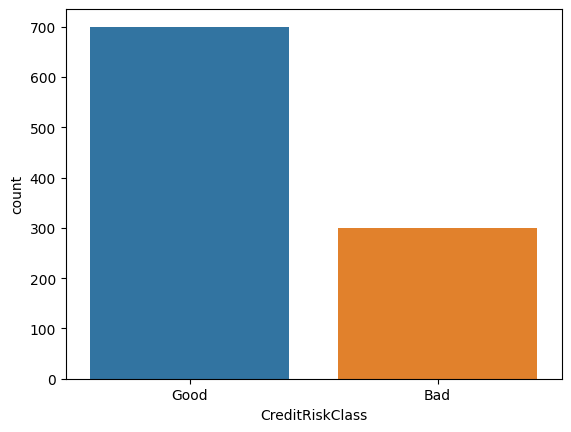

In [16]:
sns.countplot(x="CreditRiskClass", data=dataset_df, hue="CreditRiskClass")
dataset_df["CreditRiskClass"].value_counts()/number_samples

The dataset is highly unbalanced between the classes "Good payers" and "Bad payers"

### Analysis of Numerical Features

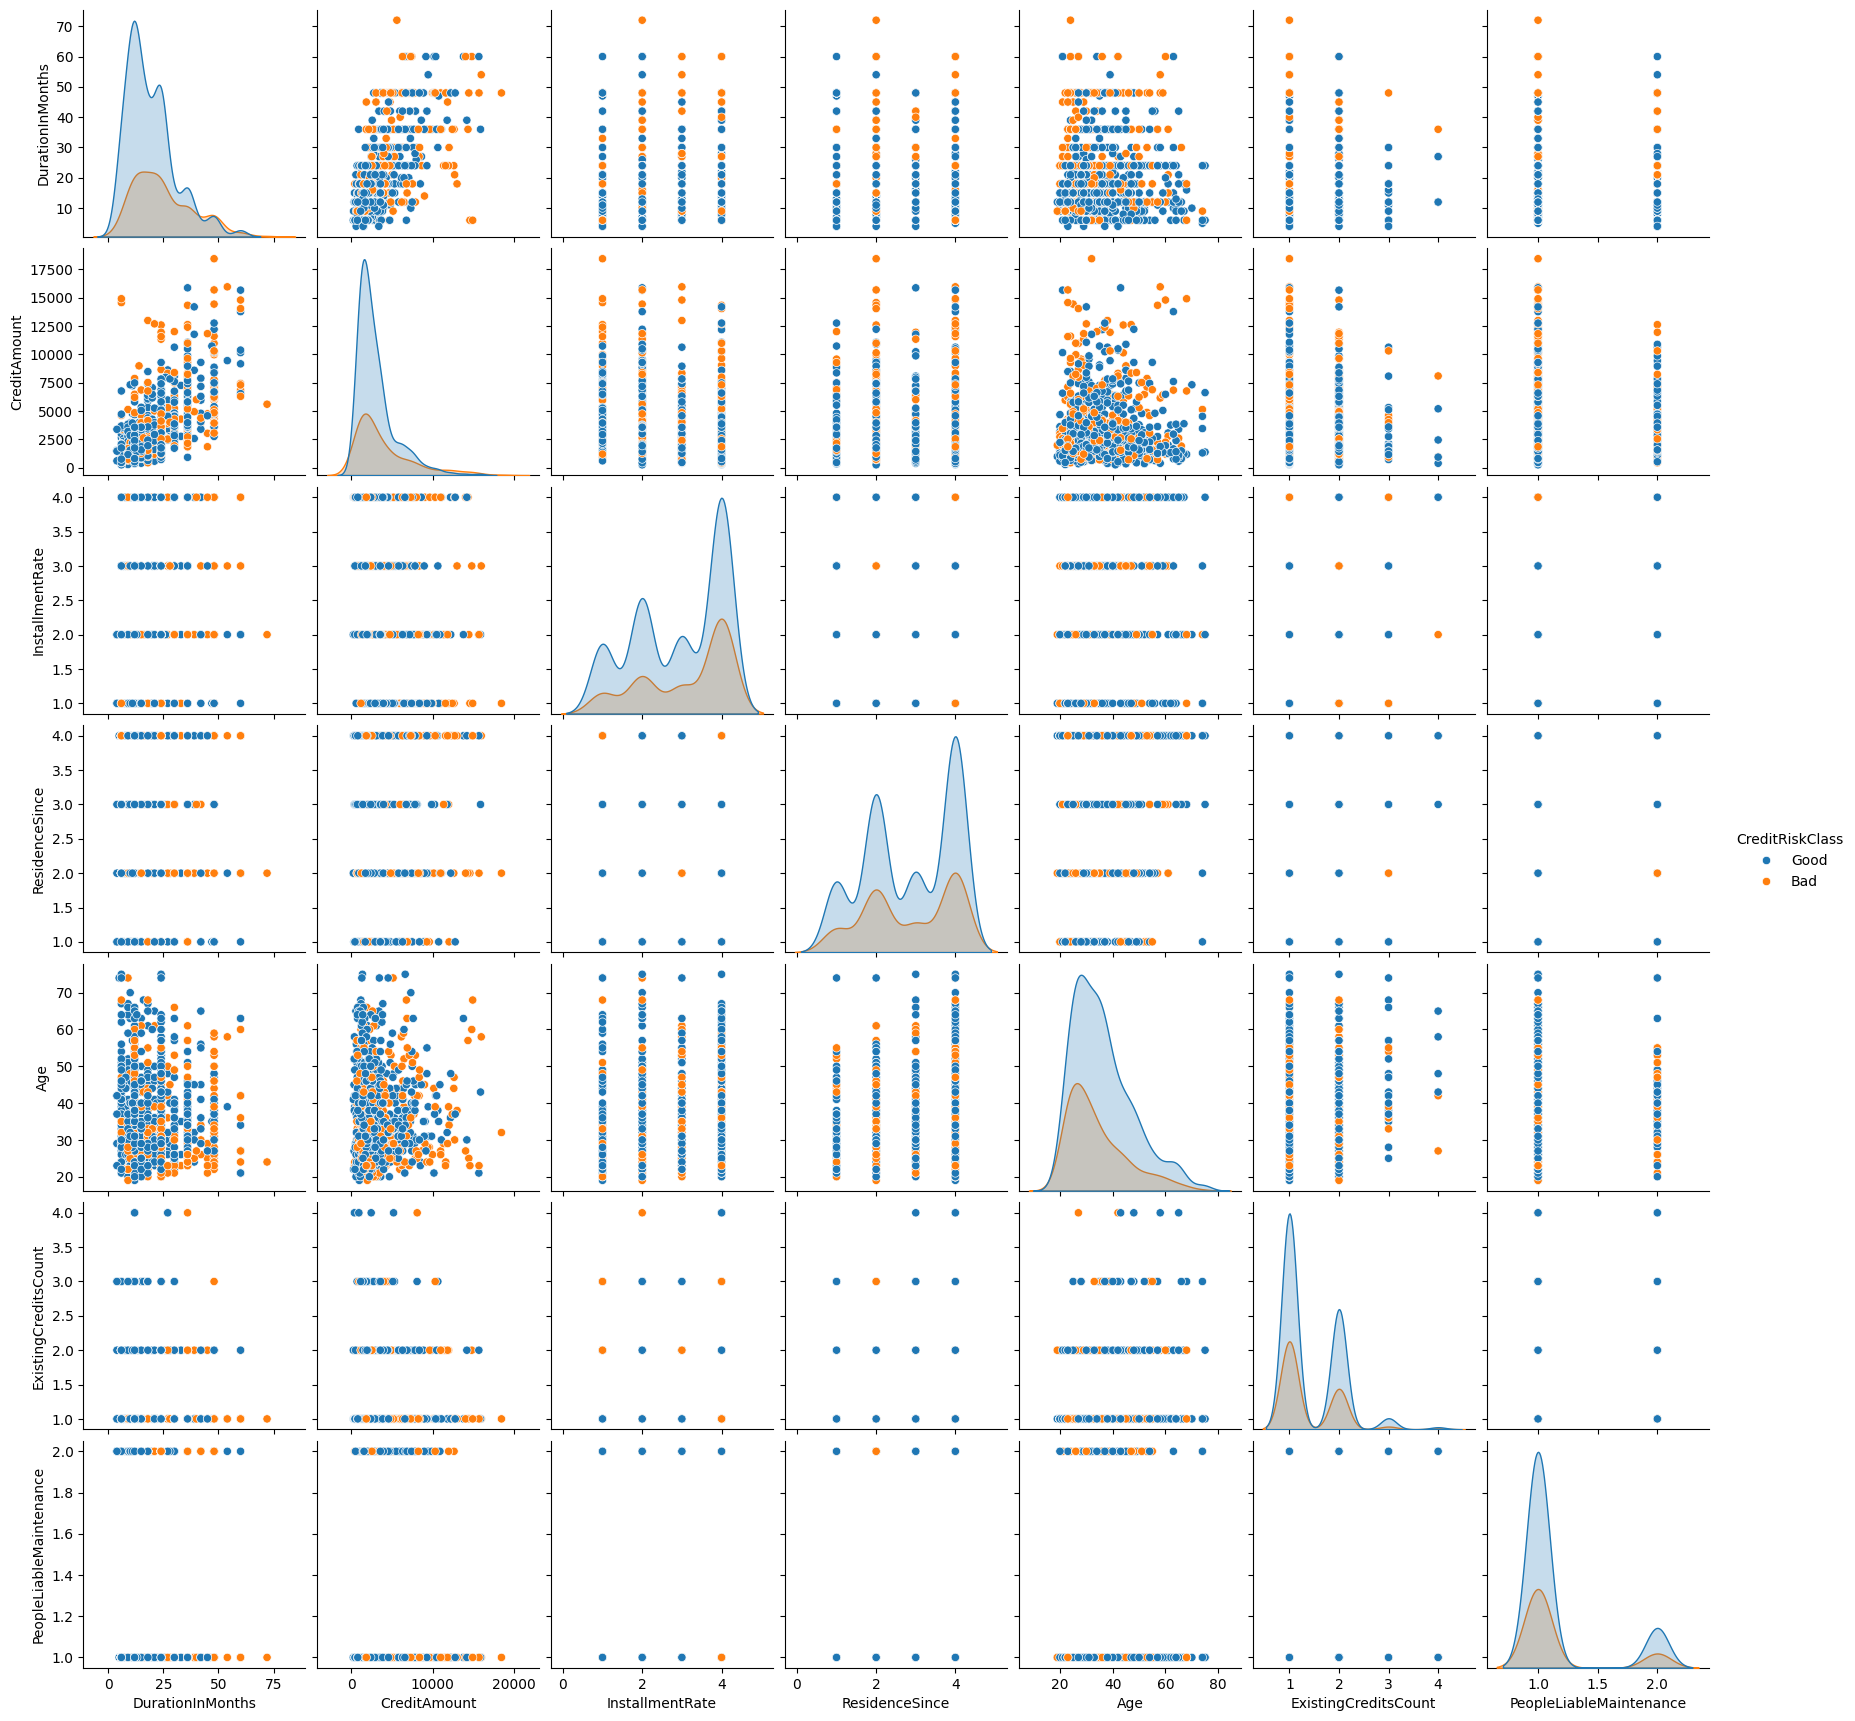

In [17]:
sns.pairplot(dataset_df, hue="CreditRiskClass")

#### 1. Univariate distributions
Observing the diagonal, no features can clearly separate the two classes, what makes the classification task harder. The univariate distributions for both classes are general very similar. Apparently, the features "CreditAmount" and "DurationInMonths" are the ones how gives a higher difference in the distribution format.

#### 2. DurationInMonths and CreditAmount
In the features 'DurationInMonths' and 'CreditAmount', the distributions for each target class show a positive skewness (the mean is higher than the mode). In the target class "bad payers" however, the skewness seems to be higher (mean is further away from the mode). Besides, in the joint scatter plot DurationInMonths-CreditAmount, the concentration of "bad payers" is also higher for higher values of 
CreditAmount, specially for higher CreditAmount and lower DurationInMonths values.

#### 3. Other Numerical Features
It is possible to note that all numerical feature except for "Age", "DurationInMonths" and "CreditAmount" have only few discrete possible values (ordinal values). Therefore, a "Spearman" correlation measure is more suitable for correlation analysis, as shown below.

C:\Users\User\AppData\Local\Temp\ipykernel_12128\2364235743.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numerical_features["CreditRisk"] = dataset_df["CreditRiskClass"].replace(to_replace={"Good": 0, "Bad": 1})


<Axes: >

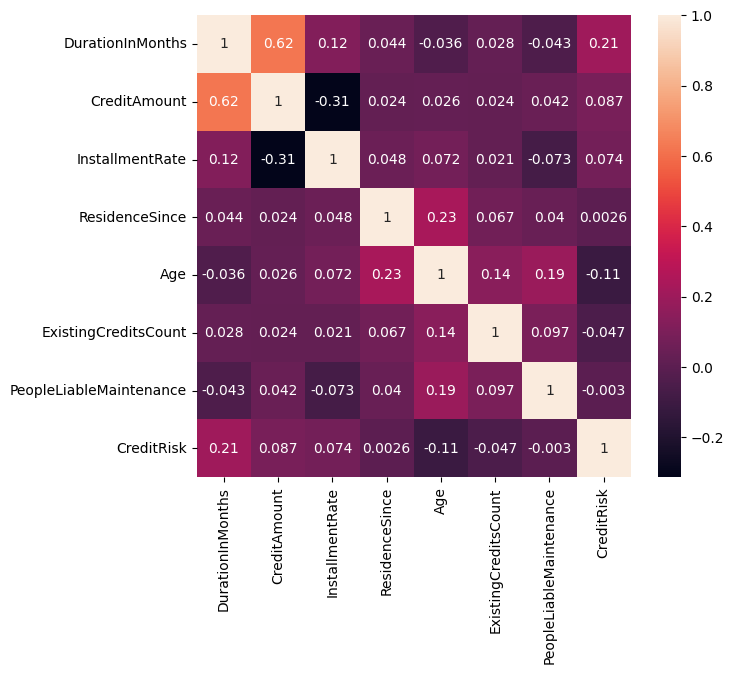

In [18]:
numerical_features = dataset_df.select_dtypes(include=["int64", "float64"])
numerical_features["CreditRisk"] = dataset_df["CreditRiskClass"].replace(to_replace={"Good": 0, "Bad": 1})

plt.figure(figsize=(7, 6))
sns.heatmap(data=numerical_features.corr(method='spearman'), annot=True)

In the heatmap above, it is possible to see that the DurationInMonths and CreditAmount are the features with the highest correlation in absolute value, followed by "InstallmentRate-CreditAmount", "ResidenceSince-Age" and "PeopleLiableMaintenance-Age".

What regards ranked correlation with the credit risk, with "0" denoting low risk (good payer) and "1" denoting high risk (bad payer), we can see that no feature has a high correlation in absolute value. The highest one is "DurationInMonths", with only "-0.27". This suggests that techniques such as Logistic Regression would not perform good. As seen below, it would be harder to fit a logistic function in the graphics below. 

Text(0, 0.5, '')

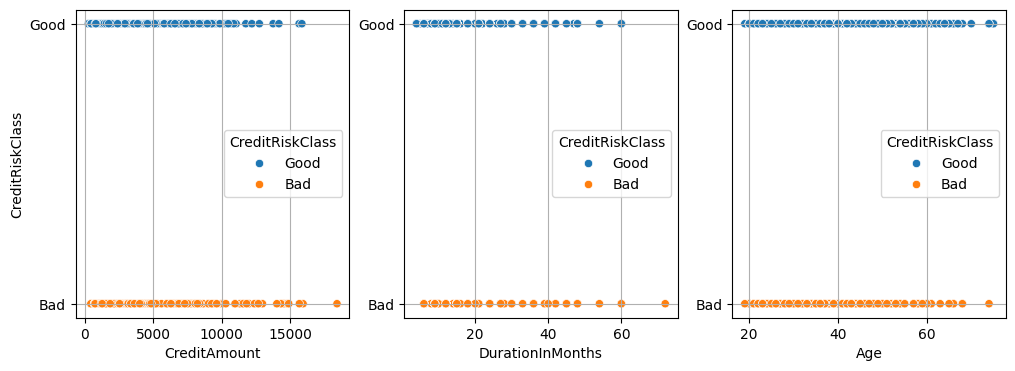

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

sns.scatterplot(ax=axes[0], x="CreditAmount", y="CreditRiskClass", data=dataset_df, hue="CreditRiskClass")
axes[0].grid()

sns.scatterplot(ax=axes[1], x="DurationInMonths", y="CreditRiskClass", data=dataset_df, hue="CreditRiskClass")
axes[1].grid()
axes[1].set_ylabel("")

sns.scatterplot(ax=axes[2], x="Age", y="CreditRiskClass", data=dataset_df, hue="CreditRiskClass")
axes[2].grid()
axes[2].set_ylabel("")

In [20]:
sns.countplot(ax=axes[1], x="Gender", hue="CreditRiskClass", data=dataset_df, stat="percent")

<Axes: xlabel='DurationInMonths', ylabel='percent'>

### Analysis of Categorical Features

(0.0, 666.75)

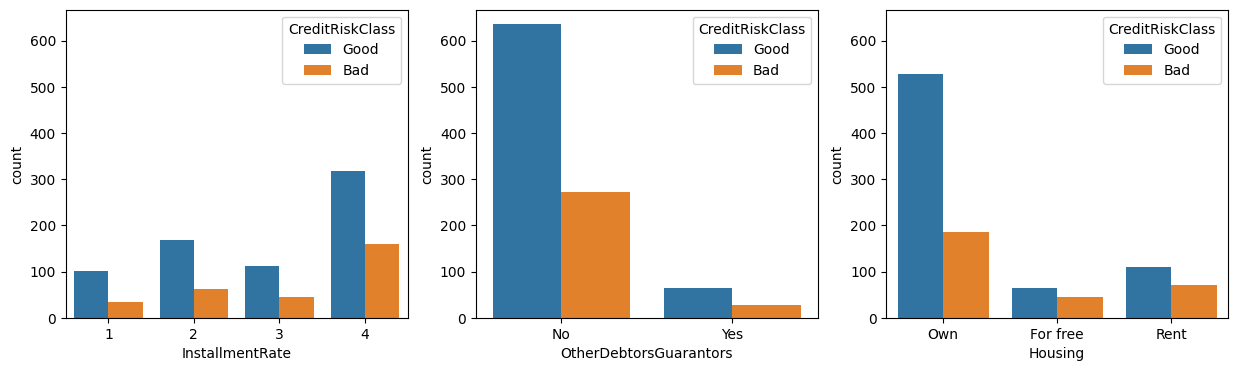

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.countplot(ax = axes[0], x="InstallmentRate", hue="CreditRiskClass", data=dataset_df)
sns.countplot(ax = axes[1], x="OtherDebtorsGuarantors", hue="CreditRiskClass", data=dataset_df)
sns.countplot(ax = axes[2], x="Housing", hue="CreditRiskClass", data=dataset_df)

max_y = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1], axes[2].get_ylim()[1])

# Set the same y-axis limit for both plots
axes[0].set_ylim(0, max_y)
axes[1].set_ylim(0, max_y)
axes[2].set_ylim(0, max_y)

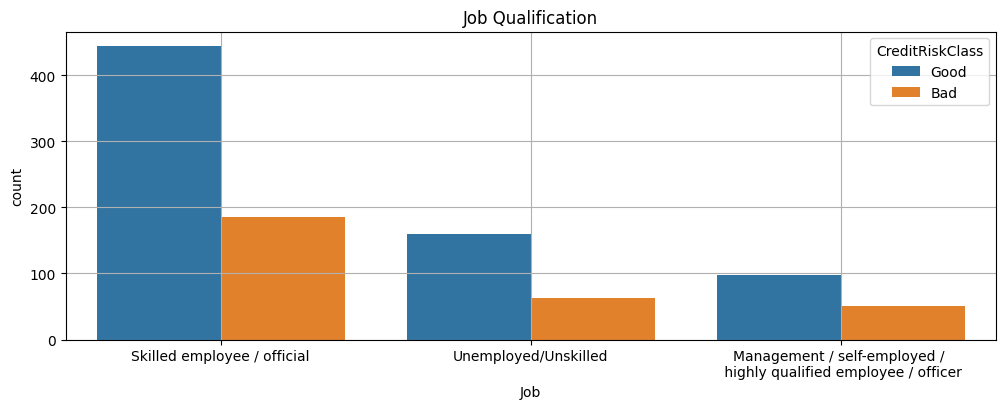

CreditRiskClass,Bad,Good,All,P(Bad|Job),P(Good|Job)
Job,,,,,
Management / self-employed / \n highly qualified employee / officer,51,97,148,0.344595,0.655405
Skilled employee / official,186,444,630,0.295238,0.704762
Unemployed/Unskilled,63,159,222,0.283784,0.716216
All,300,700,1000,0.300000,0.700000


In [22]:
plt.figure(figsize=(12, 4))
sns.countplot(x="Job", hue="CreditRiskClass", data=dataset_df)
plt.title("Job Qualification")
plt.grid()
plt.show()

create_frequency_table_with_credit_risk(index="Job", df=dataset_df)

It is possible to note that the proportion of "Good" payers and "Bad" payers remains almost the same among different categories of jobs. It is also equal to the general percentage of good and bad payers (i.e. 70%/30%). Therefore, the feature regarding the job qualification/status seems to be not relevant for the classification task.

In [23]:
create_frequency_table_with_credit_risk(index="CreditHistory", df=dataset_df)

CreditRiskClass,Bad,Good,All,P(Bad|CreditHistory),P(Good|CreditHistory)
CreditHistory,,,,,
Critical account / other credits existing,50,243,293,0.170648,0.829352
Delay in paying off in the past,28,60,88,0.318182,0.681818
Existing credits paid back duly till now,169,361,530,0.318868,0.681132
No credits taken or all credits paid back duly,53,36,89,0.595506,0.404494
All,300,700,1000,0.300000,0.700000


For some categories, like "critical account history", the rate between the target classes is quite different from the 70%/30% rate. However, for other categories such as "Existing credits paid back duly till now" and "Delay in paying off in the past", it is not. Such result suggests that the relevant of this feature should be analyzed more carefully.

CreditRiskClass,Bad,Good,All,P(Bad|CheckingAccountStatus),P(Good|CheckingAccountStatus)
CheckingAccountStatus,,,,,
0 to 200 DM,105,164,269,0.390335,0.609665
200 DM or more,14,49,63,0.222222,0.777778
Less than 0 DM,135,139,274,0.492701,0.507299
No checking account,46,348,394,0.116751,0.883249
All,300,700,1000,0.300000,0.700000


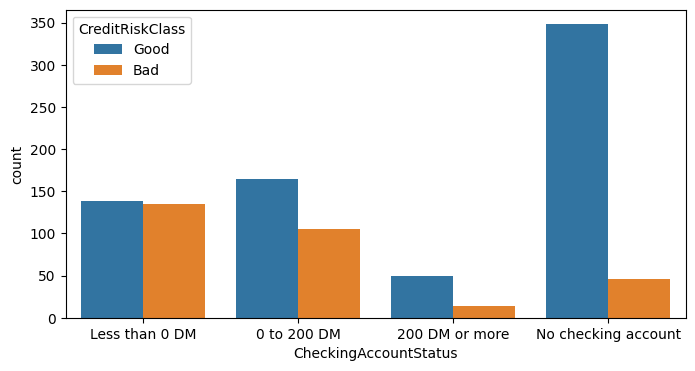

In [24]:
plt.figure(figsize=(8,4))

order_checking = ['Less than 0 DM', '0 to 200 DM', '200 DM or more', 'No checking account']

sns.countplot(x="CheckingAccountStatus", hue="CreditRiskClass", data=dataset_df, order=order_checking)

create_frequency_table_with_credit_risk(index="CheckingAccountStatus", df=dataset_df)

The feature "CheckingAccountStatus" has apparently a good capability to distinguish between the two classes. 

1. The proportion of "bad payers" in "No checking account" is very small. It is only 11%, what is quite different from the general 30/70% rate
2. The rate of the two target classes is almost the same in the category "Less than 0 DM", what is also apparently significantly different 

CreditRiskClass,Bad,Good,All,P(Bad|SavingsAccountBonds),P(Good|SavingsAccountBonds)
SavingsAccountBonds,,,,,
100 to 500 DM,34,69,103,0.330097,0.669903
500 DM or more,17,94,111,0.153153,0.846847
Less than 100 DM,217,386,603,0.359867,0.640133
Unknown / no savings account,32,151,183,0.174863,0.825137
All,300,700,1000,0.300000,0.700000


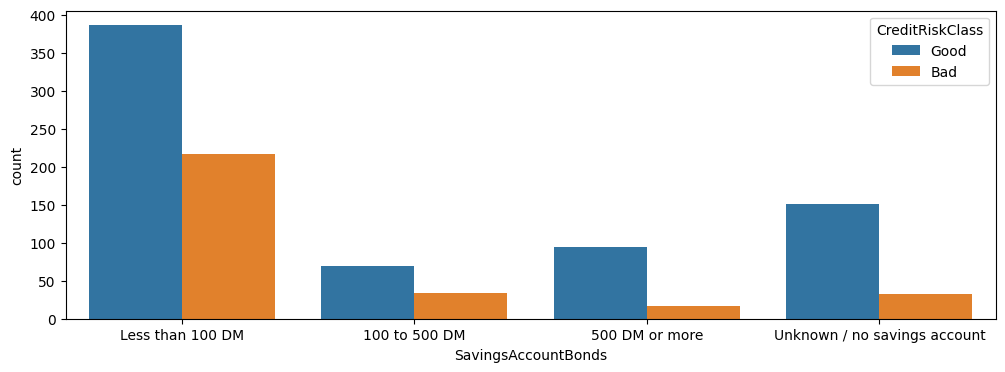

In [25]:
plt.figure(figsize=(12,4))
order_savings = ['Less than 100 DM','100 to 500 DM','500 DM or more', 'Unknown / no savings account']
sns.countplot(x="SavingsAccountBonds", hue="CreditRiskClass", data=dataset_df, order=order_savings)

create_frequency_table_with_credit_risk(index="SavingsAccountBonds", df=dataset_df)

## Hypothesis Test

## Classification Model for Prediction

#### Pre-processing

#### Data-Splitting

#### Model Selection

#### Analysis

## Conclusion

## Citation